<span style="font-family: 'Times New Roman'; font-size: 24px; color: white; font-weight: bold;">Model Analysis</span>

<p style="text-align: center; font-family: 'Times New Roman'; color: white;">CAROLINA LOPEZ DE LA MADRIZ</p>
<p style="text-align: center; font-family: 'Times New Roman'; color: white;">JAIME SALAFRANCA PARDO</p>
<p style="text-align: center; font-family: 'Times New Roman'; color: white;">ALVARO MARTIN RUIZ</p>
<p style="text-align: center; font-family: 'Times New Roman'; color: white; font-weight: bold; font-size: 18px;">Group: Biodata</p>


<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Import libraries and load data</span>

In [1]:
import processing_functions as pf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Prepare data</span>

In [2]:
df = pd.read_csv('dataset_fase2.csv')
df.head(5)

,LOTE,Fecha/hora inicio_preinoculo,Fecha/hora fin_preinoculo,línea 1,línea 2,línea 3,línea 1.1,línea 2.1,línea 3.1,línea 1.2,...,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2,media_PV,temperature_preinoculo,humedad_preinoculo,media_temp_bioreactor,media_ph_biorreactor,media_PO_biorreactor
0,23019,2023-03-19 05:00:00,2023-03-20 07:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1747.920,6.00,0.330522,20.157241,50.339050,29.689535,6.191826,24.355140
1,23020,2023-03-19 05:00:00,2023-03-20 07:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1676.160,6.56,0.426711,20.157241,50.339050,29.689535,6.191826,24.355140
2,23021,2023-03-20 05:00:00,2023-03-21 06:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1928.496,8.08,0.409436,20.173527,52.099099,29.439842,6.028036,25.462923
3,23022,2023-03-20 05:00:00,2023-03-21 06:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1782.800,5.92,0.080985,20.173527,52.099099,29.439842,6.028036,25.462923
4,23023,2023-03-26 05:00:00,2023-03-27 07:21:00,5.496,5.504,5.5200000000000005,28.32,27.92,32,1.0,...,26.56,20.88,1861.840,2.96,0.368708,20.251146,48.900195,29.442474,6.002998,23.396945


In [3]:
target = df.iloc[:,41]
columns_to_drop = df.iloc[:, [0,1,2,13,14,12,22,23,24,30,31,32,33,38,41,42]].columns

df_dropped = df.drop(columns=columns_to_drop)

In [4]:
df.iloc[:,0]

0      23019
1      23020
2      23021
3      23022
4      23023
       ...  
126    24045
127    24044
128    24049
129    24050
130    24051
Name: LOTE, Length: 131, dtype: int64

In [4]:
data = df_dropped
data.replace('N.A', np.nan, inplace=True)

In [5]:
data['línea 3'] = data['línea 3'].astype(float)
data['línea 3.1'] = data['línea 3.1'].astype(float)
data['Viabilidad final cultivo_cultivo_final'] = data['Viabilidad final cultivo_cultivo_final'].astype(float)

In [6]:
def clean_and_convert(column):
    """
    Cleans and converts a string column to numeric values.
    
    This function performs the following steps:
    1. Replaces commas (',') with dots ('.') for decimal separator consistency.
    2. Removes any '+' signs from the values.
    3. Converts the cleaned column to numeric type (float), with invalid values set to NaN.

    Parameters:
    column (pandas.Series): A column of strings (potentially containing numbers in string format) to clean and convert.
    
    Returns:
    pandas.Series: A column with cleaned and converted numeric values.
    """
    
    # Step 1: Replace commas with dots to standardize the decimal separator
    # Example: '1,234' becomes '1.234' (useful for handling European-style numbers with commas as decimals)
    column = column.str.replace(',', '.', regex=False)
    
    # Step 2: Remove the '+' sign
    # This removes any plus signs (e.g., '+123.45') that might be present in the data
    column = column.str.replace('+', '', regex=False)
    
    # Step 3: Convert the cleaned column to numeric (float) type
    # The 'errors='coerce'' argument ensures that any values that cannot be converted (e.g., non-numeric text) 
    # are replaced with NaN (Not a Number).
    return pd.to_numeric(column, errors='coerce')

In [7]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = clean_and_convert(data[col])

In [8]:
for column in data.select_dtypes(include=[np.number]).columns:
    mean_value = data[column].mean()
    print(mean_value)
    data[column].fillna(mean_value, inplace=True) 

5.468736
5.470035087719299
5.498217821782178
32.061440000000005
30.212631578947367
29.801188118811883
0.8188976377952756
0.6456692913385826
0.41732283464566927
150.5514503816794
15.36064
26.362137404580157
99092268.70229007
13.696641221374044
20.1720479825518
44926560.913380995
150.5514503816794
15.36064
26.362137404580157
99092268.70229007
1.0
81.55658914728681
17.380763358778626
74.06106870229007
168240203.56234095
30.287401574803148
23.35516129032258
0.3661848971527833
20.16984734592939
47.94785228808695
29.45899697760463
6.965512947242943
27.171243680776026


In [9]:
for column in data.select_dtypes(exclude=[np.number]).columns:
    mode_value = data[column].mode()[0]  # Use the most frequent value
    data[column].fillna(mode_value, inplace=True)

In [10]:
target.dtypes

dtype('float64')

<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Divide data into train, validation and test sets</span>

In [11]:
X = data
y = target

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% entrenamiento
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% validación, 20% prueba

<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Feature Importance Evaluation</span>

<span style="font-family: 'Times New Roman'; font-size: 20px; color: white; font-weight: bold;">Using Random Forest Regressor</span>

In [13]:
# RandomForest model to get feature importance
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)


importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("Top 10 most important features:")
print(importance_df.head(10))
relevant_features1 = importance_df.head(10)['feature'].tolist()

Top 10 most important features:
                                  feature  importance
23                   Turbidez fin cultivo    0.229837
27                               media_PV    0.126114
25              Centrifugación 1 turbidez    0.059225
21           Volumen de inóculo utilizado    0.054536
18        Turbidez final culttivo_inoculo    0.053037
26              Centrifugación 2 turbidez    0.049756
30                  media_temp_bioreactor    0.045708
22  Turbidez inicio cultivo_cultivo_final    0.032308
31                   media_ph_biorreactor    0.028749
12               Viabilidad final cultivo    0.025441


In [15]:
# Top 5
print("Top 5 most important features:")
print(importance_df.head(5))
relevant_features2 = importance_df.head(5)['feature'].tolist()

Top 5 most important features:
                            feature  importance
23             Turbidez fin cultivo    0.229837
27                         media_PV    0.126114
25        Centrifugación 1 turbidez    0.059225
21     Volumen de inóculo utilizado    0.054536
18  Turbidez final culttivo_inoculo    0.053037


In [16]:
relevant_features2

['Turbidez fin cultivo',
 'media_PV',
 'Centrifugación 1 turbidez',
 'Volumen de inóculo utilizado',
 'Turbidez final culttivo_inoculo']

<span style="font-family: 'Times New Roman'; font-size: 20px; color: white; font-weight: bold;">Using Recursive Feature Elimination</span>

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Use a linear model as the estimator
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get the features selected by RFE
selected_features_rfe = X_train.columns[rfe.support_]
print("Top 10 features selected by RFE:")
print(selected_features_rfe)

Top 10 features selected by RFE:
Index(['línea 1', 'línea 2', 'línea 3', 'línea 2.2', 'línea 3.2',
       'Cantidad entregada', 'Volumen de inóculo utilizado', 'media_PV',
       'temperature_preinoculo', 'media_temp_bioreactor'],
      dtype='object')


<span style="font-family: 'Times New Roman'; font-size: 20px; color: white; font-weight: bold;">Using Permutation Feature Importance</span>

In [19]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Store the importance scores
permutation_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
})

permutation_importance_df = permutation_importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 features based on Permutation Importance:")
print(permutation_importance_df.head(10))
relevant_features_perm = permutation_importance_df.head(10)['Feature'].tolist()

Top 10 features based on Permutation Importance:
                                   Feature  Importance
23                    Turbidez fin cultivo    0.123030
27                                media_PV    0.086481
29                      humedad_preinoculo    0.045448
30                   media_temp_bioreactor    0.041586
18         Turbidez final culttivo_inoculo    0.024060
10                 Turbidez inicio cultivo    0.008676
24  Viabilidad final cultivo_cultivo_final    0.008123
17         Turbidez inicio cultivo_inoculo    0.003585
13                      Cantidad entregada    0.002867
11                 Turbidez final culttivo    0.002606


<span style="font-family: 'Times New Roman'; font-size: 20px; color: white; font-weight: bold;">Using SHAP</span>

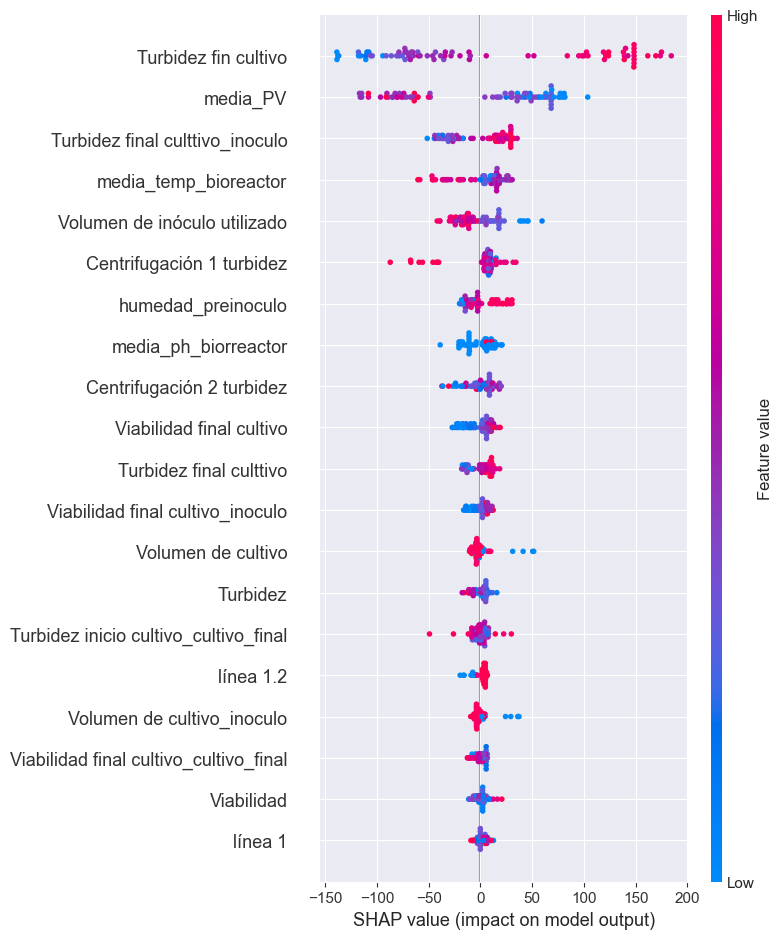

Top 10 features based on SHAP values:
                            Feature  Importance
23             Turbidez fin cultivo   94.135382
27                         media_PV   62.468669
18  Turbidez final culttivo_inoculo   24.861374
30            media_temp_bioreactor   19.070958
21     Volumen de inóculo utilizado   17.612475
25        Centrifugación 1 turbidez   14.872556
29               humedad_preinoculo   12.970465
31             media_ph_biorreactor   10.819662
26        Centrifugación 2 turbidez   10.362668
12         Viabilidad final cultivo   10.108031


In [20]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

# Plot the summary plot
shap.summary_plot(shap_values, X_train)

# Alternatively, get the mean SHAP value for each feature
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.mean(np.abs(shap_values), axis=0)
})

shap_importance = shap_importance.sort_values(by='Importance', ascending=False)
print("Top 10 features based on SHAP values:")
print(shap_importance.head(10))

In [22]:
# Extract the top 10 most important features
shap_important_10 = shap_importance.head(10)['Feature'].tolist()

<span style="font-family: 'Times New Roman'; font-size: 20px; color: white; font-weight: bold;">Choose the features for the model</span>

<p style="font-family: 'Times New Roman'; font-size: 15px; color: white;">To train the model with some relevant features only, execute the next cells</p>

In [62]:
selected_features = relevant_features2 # change by the features from one of the previous techniques

In [63]:
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]
X_val_reduced = X_val[selected_features]

In [48]:
X_train = X_train_reduced
X_test = X_test_reduced
X_val = X_val_reduced

In [49]:
X_train.head()

,Turbidez fin cultivo,media_PV,Centrifugación 1 turbidez,Volumen de inóculo utilizado,Turbidez final culttivo_inoculo
129,67.60,0.366185,29.44,84.16,25.92
53,83.20,0.595076,22.64,80.80,28.16
5,80.80,0.006498,24.56,76.00,31.68
68,64.64,1.013365,25.28,80.80,28.48
73,68.88,0.474064,27.84,80.40,23.28


<span style="font-family: 'Times New Roman'; font-size: 24px; color: white; font-weight: bold;">MODEL ANALYSIS</span>

<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 1: XGB Regressor</span>

In [50]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),               # Feature scaling
    ('regressor', XGBRegressor(random_state=42))  # XGBoost model
])

# Define the hyperparameters to tune
param_distributions = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform Random Search to find the best parameters
random_search = GridSearchCV(pipeline, param_distributions, cv=5, 
                             scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Train the model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV] END regressor__colsample_bytree=0.6, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=100, regressor__subsample=0.6; total time=   0.1s
[CV] END regressor__colsample_bytree=0.6, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=100, regressor__subsample=0.8; total time=   0.1s
[CV] END regressor__colsample_bytree=0.6, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=200, regressor__subsample=0.6; total time=   0.1s
[CV] END regressor__colsample_bytree=0.6, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=200, regressor__subsample=1.0; total time=   0.1s
[CV] END regressor__colsample_bytree=0.6, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_child_weight=1,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_ty...
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'regressor__colsample_bytree': [0.6, 0.8, 1.0],
                         'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'regressor__max_depth': [3, 5, 7, 10],
                         'regressor__min_child_weight': [1, 3, 5],
                         'regressor__n_estimators': [100, 200, 300, 500],
                         'regressor__subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 1 Results</span>

In [51]:
print("Best parameters found:", random_search.best_params_)

y_val_pred = random_search.predict(X_val)

mse_val = mean_squared_error(y_val, y_val_pred)
print("Root Mean Squared Error on the validation set:", np.sqrt(mse_val))

Best parameters found: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 1.0}
Root Mean Squared Error on the validation set: 308.26668629102454


In [52]:
y_test_pred = random_search.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Root Mean Squared Error on the test set:", np.sqrt(mse_test))

Root Mean Squared Error on the test set: 312.51497316986456


<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 2: Ridge</span>

In [53]:
from sklearn.impute import SimpleImputer
# Define the Ridge regression pipeline
ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Replace 'mean' with 'median' or 'most_frequent' if preferred
    ('scaler', StandardScaler()),                # Feature scaling
    ('model', Ridge())                           # Ridge regression model
])

# Define the hyperparameter grid for tuning
ridge_param_grid = {'model__alpha': [0.1, 1.0, 10.0, 100.0]}  # Regularization strength parameter

# Perform Grid Search for hyperparameter tuning
ridge_grid_search = GridSearchCV(estimator=ridge_pipeline, param_grid=ridge_param_grid, cv=5, 
                                 scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Train the model
ridge_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', Ridge())]),
             n_jobs=-1, param_grid={'model__alpha': [0.1, 1.0, 10.0, 100.0]},
             scoring='neg_mean_squared_error', verbose=2)

<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 2 Results</span>

In [54]:
y_pred_ridge = ridge_grid_search.best_estimator_.predict(X_val)

rmse_ridge = np.sqrt(mean_squared_error(y_val, y_pred_ridge))
r2_ridge = r2_score(y_val, y_pred_ridge)

print(f"Ridge Regression - Best Params: {ridge_grid_search.best_params_}, RMSE: {rmse_ridge}, R2: {r2_ridge}")

Ridge Regression - Best Params: {'model__alpha': 100.0}, RMSE: 325.58736083849743, R2: 0.21052393641759537


In [55]:
# Predict on the test set using the best model
y_test_ridge = ridge_grid_search.best_estimator_.predict(X_test)

# Compute RMSE and R2 on the test set
rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_test_ridge))
r2_ridge_test = r2_score(y_test, y_test_ridge)

print(f"Ridge Regression: RMSE: {rmse_ridge_test}, R2: {r2_ridge_test}")

Ridge Regression: RMSE: 228.9683023241817, R2: 0.22836312610838505


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

# Define the better pipeline with enhancements
better_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Use 'median' for more robustness to outliers
    ('scaler', RobustScaler()),                     # Use RobustScaler to handle outliers better
    ('model', Ridge())                              # Ridge regression model
])

# Define the hyperparameter grid for tuning, expanded
better_param_grid = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Adding a finer range of alpha values
}

# Using a voting regressor for combining different models
voting_regressor = VotingRegressor(estimators=[
    ('ridge', Ridge(alpha=1.0)),
    ('lasso', Lasso(alpha=0.01)),
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.7))  # Adding ElasticNet as a hybrid model
])

# Define the grid for the ensemble model
voting_param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0],
    'lasso__alpha': [0.01, 0.1, 1.0],
    'elasticnet__alpha': [0.01, 0.1, 1.0],
    'elasticnet__l1_ratio': [0.5, 0.7, 0.9]
}

# Perform Grid Search for hyperparameter tuning on ensemble model
voting_grid_search = GridSearchCV(estimator=voting_regressor, param_grid=voting_param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Train the ensemble model
voting_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=VotingRegressor(estimators=[('ridge', Ridge()),
                                                   ('lasso', Lasso(alpha=0.01)),
                                                   ('elasticnet',
                                                    ElasticNet(alpha=0.01,
                                                               l1_ratio=0.7))]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': [0.01, 0.1, 1.0],
                         'elasticnet__l1_ratio': [0.5, 0.7, 0.9],
                         'lasso__alpha': [0.01, 0.1, 1.0],
                         'ridge__alpha': [0.01, 0.1, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [57]:
y_pred_voting = voting_grid_search.best_estimator_.predict(X_val)

rmse_voting = np.sqrt(mean_squared_error(y_val, y_pred_voting))
r2_voting = r2_score(y_val, y_pred_voting)

print(f"Voting - Best Params: {voting_grid_search.best_params_}, RMSE: {rmse_voting}, R2: {r2_voting}")

Voting - Best Params: {'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 0.5, 'lasso__alpha': 1.0, 'ridge__alpha': 1.0}, RMSE: 296.71474448404916, R2: 0.3443347781499897


In [58]:
# Predict on the test set using the best model
y_test_voting = voting_grid_search.best_estimator_.predict(X_test)

# Compute RMSE and R2 on the test set
rmse_voting_test = np.sqrt(mean_squared_error(y_test, y_test_voting))
r2_voting_test = r2_score(y_test, y_test_voting)

print(f"Voting: RMSE: {rmse_voting_test}, R2: {r2_voting_test}")

Voting: RMSE: 217.71837189358197, R2: 0.302326221463705


<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 3: Random Forest Regressor</span>

In [33]:
# Define the Random Forest Regressor pipeline
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation using the mean (alternatively, use 'median' or 'most_frequent')
    ('scaler', StandardScaler()),                # Feature scaling
    ('model', RandomForestRegressor(random_state=42))  # Random Forest Regressor model
])

# Define the hyperparameter grid for tuning the Random Forest model
rf_param_grid = {
    'model__n_estimators': [100, 200],          # Number of trees in the forest
    'model__max_depth': [None, 10, 20],         # Maximum depth of each tree
    'model__min_samples_split': [2, 5],         # Minimum number of samples required to split an internal node
    'model__min_samples_leaf': [1, 2],          # Minimum number of samples required to be at a leaf node
    'model__max_features': ['auto', 'sqrt']     # Number of features to consider when looking for the best split
}

# Perform Grid Search for hyperparameter tuning using cross-validation
rf_grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, cv=5, 
                              scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Train the Random Forest model with the best hyperparameters
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__min_child_weight=3, regressor__n_estimators=100, regressor__subsample=1.0; total time=   0.1s
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__min_child_weight=3, regressor__n_estimators=200, regressor__subsample=0.6; total time=   0.3s
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__min_child_weight=3, regressor__n_estimators=200, regressor__subsample=1.0; total time=   0.3s
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__min_child_weight=3, regressor__n_estimators=300, regressor__subsample=0.8; total time=   0.4s
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__min_child_weight=3, regress


120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__max_features': ['auto', 'sqrt'],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 3 Results</span>

In [34]:
y_pred_rf = rf_grid_search.best_estimator_.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2_rf = r2_score(y_val, y_pred_rf)

print(f"Random Forest Regression - Best Params: {rf_grid_search.best_params_}, RMSE: {rmse_rf}, R2: {r2_rf}")

Random Forest Regression - Best Params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}, RMSE: 303.06032402072634, R2: 0.31599061799927275


In [35]:
y_test_rf = rf_grid_search.best_estimator_.predict(X_test)

rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_test_rf))
r2_rf_test = r2_score(y_test, y_test_rf)

print(f"Random Forest Regression: RMSE: {rmse_rf_test}, R2: {r2_rf_test}")

Random Forest Regression: RMSE: 245.46493613284537, R2: 0.1131683761050003


<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 4: Gradient Boosting Regressor</span>

In [36]:
# Define the Gradient Boosting Regressor pipeline
gbr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation using the mean (alternatively, use 'median' or 'most_frequent')
    ('scaler', StandardScaler()),                # Feature scaling
    ('model', GradientBoostingRegressor(random_state=42))  # Gradient Boosting Regressor model
])

# Define the hyperparameter grid for tuning the Gradient Boosting model
gbr_param_grid = {
    'model__n_estimators': [100, 200],           # Number of boosting stages (trees)
    'model__learning_rate': [0.01, 0.1],         # Step size at each iteration
    'model__max_depth': [3, 5],                  # Maximum depth of each individual tree
    'model__min_samples_split': [2, 5],          # Minimum samples required to split an internal node
    'model__min_samples_leaf': [1, 2],           # Minimum samples required to be at a leaf node
    'model__max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Perform Grid Search for hyperparameter tuning using cross-validation
gbr_grid_search = GridSearchCV(estimator=gbr_pipeline, param_grid=gbr_param_grid, cv=5, 
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Train the Gradient Boosting model with the best hyperparameters
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=10, regressor__min_child_weight=5, regressor__n_estimators=200, regressor__subsample=1.0; total time=   0.3s
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=10, regressor__min_child_weight=5, regressor__n_estimators=300, regressor__subsample=0.6; total time=   0.3s
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=10, regressor__min_child_weight=5, regressor__n_estimators=300, regressor__subsample=1.0; total time=   0.4s
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=10, regressor__min_child_weight=5, regressor__n_estimators=500, regressor__subsample=0.6; total time=   0.5s
[CV] END regressor__colsample_bytree=1.0, regressor__learning_rate=0.1, regressor__max_depth=10, regressor__min_child_weight=5, re


160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
88 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 5],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 4 Results</span>

In [37]:
y_pred_gbr = gbr_grid_search.best_estimator_.predict(X_val)

rmse_gbr = np.sqrt(mean_squared_error(y_val, y_pred_gbr))
r2_gbr = r2_score(y_val, y_pred_gbr)

print(f"Gradient Boosting - Best Params: {gbr_grid_search.best_params_}, RMSE: {rmse_gbr}, R2: {r2_gbr}")

Gradient Boosting - Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}, RMSE: 297.65891127094915, R2: 0.3401553952316676


In [38]:
y_test_gbr = gbr_grid_search.best_estimator_.predict(X_test)

rmse_gbr_test = np.sqrt(mean_squared_error(y_test, y_test_gbr))
r2_gbr_test = r2_score(y_test, y_test_gbr)

print(f"Gradient Boosting: RMSE: {rmse_gbr_test}, R2: {r2_gbr_test}")

Gradient Boosting: RMSE: 276.3401610181277, R2: -0.1239584516291663


<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 5: KNN Regressor</span>

In [39]:
 # K-Nearest Neighbors (KNN) Regressor
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

# GridSearchCV for KNN
knn_param_grid = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance']
}

knn_grid_search = GridSearchCV(estimator=knn_pipeline, param_grid=knn_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [3, 5, 7, 9],
                         'model__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">Model 5 Results</span>

In [40]:
y_pred_knn = knn_grid_search.best_estimator_.predict(X_val)

rmse_knn = np.sqrt(mean_squared_error(y_val, y_pred_knn))
r2_knn = r2_score(y_val, y_pred_knn)

print(f"KNN - Best Params: {knn_grid_search.best_params_}, RMSE: {rmse_knn}, R2: {r2_knn}")

KNN - Best Params: {'model__n_neighbors': 9, 'model__weights': 'uniform'}, RMSE: 327.42056029794236, R2: 0.2016087164710454


In [41]:
y_test_knn = knn_grid_search.best_estimator_.predict(X_test)

rmse_knn_test = np.sqrt(mean_squared_error(y_test, y_test_knn))
r2_knn_test = r2_score(y_test, y_test_knn)

print(f"KNN: RMSE: {rmse_knn_test}, R2: {r2_knn_test}")

KNN: RMSE: 266.87418431160756, R2: -0.04827535268028749


<span style="font-family: 'Times New Roman'; font-size: 22px; color: white; font-weight: bold;">More Models...</span>

In [44]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define models and parameters
models = [
    {
        'name': 'Linear Regression',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ]),
        'param_grid': {}
    },
    {
        'name': 'Ridge Regression',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', Ridge())
        ]),
        'param_grid': {
            'model__alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    {
        'name': 'Lasso Regression',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', Lasso(max_iter=10000))
        ]),
        'param_grid': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    {
        'name': 'ElasticNet Regression',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', ElasticNet(max_iter=10000))
        ]),
        'param_grid': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0],
            'model__l1_ratio': [0.1, 0.5, 0.9]  # Mix of Lasso (1) and Ridge (0)
        }
    },
    {
        'name': 'Bayesian Ridge',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', BayesianRidge())
        ]),
        'param_grid': {}
    },
    {
        'name': 'SGD Regression',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', SGDRegressor())
        ]),
        'param_grid': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0],
            'model__penalty': ['l2', 'l1', 'elasticnet'],
            'model__max_iter': [1000, 2000]
        }
    },
    {
        'name': 'Random Forest',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42))
        ]),
        'param_grid': {
            'model__n_estimators': [100, 200, 500, 1000],
            'model__max_depth': [None, 10, 20, 50],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__max_features': ['auto', 'sqrt', 'log2']
        }
    },
    {
        'name': 'Gradient Boosting',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        'param_grid': {
            'model__n_estimators': [100, 200, 500],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__max_features': ['auto', 'sqrt', 'log2']
        }
    },
    {
        'name': 'Support Vector Regression',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', SVR())
        ]),
        'param_grid': {
            'model__C': [0.1, 1.0, 10.0],
            'model__epsilon': [0.01, 0.1, 1.0],
            'model__kernel': ['linear', 'rbf']
        }
    },
    {
        'name': 'K-Nearest Neighbors',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', KNeighborsRegressor())
        ]),
        'param_grid': {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__weights': ['uniform', 'distance']
        }
    },
    {
        'name': 'XGBoost',
        'estimator': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', XGBRegressor(random_state=42))
        ]),
        'param_grid': {
            'model__n_estimators': [100, 200, 500],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        }
    }
]

In [45]:
# Search type: 'grid' or 'random'
search_type = 'grid'

best_models = {}

# Train and optimize models
for m in models:
    print(f"Training and optimizing model: {m['name']}")
    
    search = GridSearchCV(
        estimator=m['estimator'],
        param_grid=m['param_grid'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    ) if search_type == 'grid' else RandomizedSearchCV(
        estimator=m['estimator'],
        param_distributions=m['param_grid'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        n_iter=20
    )
    
    try:
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        y_pred_val = best_model.predict(X_val)
        mse_val = mean_squared_error(y_val, y_pred_val)
        rmse_val = np.sqrt(mse_val)
        r2_val = r2_score(y_val, y_pred_val)

        best_models[m['name']] = {
            'model': best_model,
            'best_params': search.best_params_,
            'best_score': -search.best_score_,
            'rmse_val': rmse_val,
            'mse_val': mse_val,
            'r2_val': r2_val
        }
        
        print(f"Best hyperparameters for {m['name']}: {search.best_params_}")
        print(f"MSE on validation for {m['name']}: {mse_val}")
        print(f"RMSE on validation for {m['name']}: {rmse_val}")
        print(f"R2 on validation for {m['name']}: {r2_val}")
        print("-" * 50)
    except Exception as e:
        print(f"Error training {m['name']}: {e}")

Training and optimizing model: Linear Regression
Best hyperparameters for Linear Regression: {}
MSE on validation for Linear Regression: 71110.83560424167
RMSE on validation for Linear Regression: 266.6661500907861
R2 on validation for Linear Regression: 0.47041012415221173
--------------------------------------------------
Training and optimizing model: Ridge Regression
Best hyperparameters for Ridge Regression: {'model__alpha': 100.0}
MSE on validation for Ridge Regression: 102193.44572270491
RMSE on validation for Ridge Regression: 319.6770960245743
R2 on validation for Ridge Regression: 0.23892591371100746
--------------------------------------------------
Training and optimizing model: Lasso Regression
Best hyperparameters for Lasso Regression: {'model__alpha': 10.0}
MSE on validation for Lasso Regression: 73668.01660346861
RMSE on validation for Lasso Regression: 271.4185266400741
R2 on validation for Lasso Regression: 0.4513658089449223
------------------------------------------


720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
341 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_para

Best hyperparameters for Random Forest: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}
MSE on validation for Random Forest: 91845.55999554764
RMSE on validation for Random Forest: 303.06032402072634
R2 on validation for Random Forest: 0.31599061799927275
--------------------------------------------------
Training and optimizing model: Gradient Boosting


KeyboardInterrupt: 

In [ ]:
# Comparison of models by RMSE
print("Model comparison by RMSE on validation:\n")
for name, info in best_models.items():
    print(f"Model: {name}")
    print(f"RMSE on validation: {info['rmse_val']}")
    print("-" * 50)

In [ ]:
# Find the best model based on RMSE
best_model_name = min(best_models, key=lambda x: best_models[x]['rmse_val'])
print(f"The best model based on RMSE on validation is: {best_model_name} with {best_models[best_model_name]['rmse_val']}")

In [43]:
# Evaluate best model on test set
best_model_name = min(best_models, key=lambda k: best_models[k]['best_score'])
best_model = best_models[best_model_name]['model']
y_pred_test = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

[CV] END model__learning_rate=0.01, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__max_features=sqrt, model__min_sa


KeyboardInterrupt



In [ ]:
print(f"Performance on the test set with {best_model_name}:")
print(f"MSE on test: {mse_test}")
print(f"R2 on test: {r2_test}")
print(f"RMSE on test: {rmse_test}")